# Print 2D images from PRISM simulation outputs

In [81]:
import os
import numpy as np
import py4DSTEM
from py4DSTEM.visualize import show
import matplotlib.pyplot as plt
import yaml

In [82]:
import PIL

Use py4DSTEM python module to read the data. The `check_config()` function is helpful to make sure the library is installed correctly. For now, the first line shoul dsay "all Dependencies for Base are Installed". You can igmore the rest

In [83]:
py4DSTEM.check_config()

Checking Module Dependencies
 All Dependencies for Base are Installed 
 Not All Dependencies for Ipyparallel are Installed
 Not All Dependencies for Cuda are Installed
 All Dependencies for Acom are Installed 
 Not All Dependencies for Aiml are Installed
 Not All Dependencies for Aiml-cuda are Installed
 Not All Dependencies for Numba are Installed


Choose an h5 file to open and explore

In [1]:
material_id = "mp-5229"
rotation_axis = "1_1_0"
angle = 45
combo = 15
filename = f"../prism_output_files/{material_id}_{rotation_axis}_angle_{angle}_combo_{combo}.h5"

plot_dir = '../prism_output_plots'

print(filename)

../prism_output_files/mp-5229_1_1_0_angle_45_combo_15.h5


In [85]:
# parse material name and rotation axis and angle
bname = os.path.basename(filename)
slist = bname.split('_')

with open('../materials_map.yml', 'r') as f:
    mat_map = yaml.safe_load(f)
formula = mat_map[material_id]['pretty_formula']



rotation_axis = [int(i) for i in slist[1:4]]
rotation_string = f"[{rotation_axis[0]}{rotation_axis[1]}{rotation_axis[2]}]"
angle = int(slist[-1].split('.')[0])


plt_title = f"{formula} {rotation_string} {angle} deg"
plt_bname = f"{bname.split('.')[0]}"
# plt_fname = f"{bname.split('.')[0]}.png"

The `print_h5_tree` function prints the structure of the h5 simulation

In [86]:
py4DSTEM.io.print_h5_tree(filename)

/
|--4DSTEM_simulation
	|--data
	|	|--counted_datacubes
	|	|--datacubes
	|	|	|--CBED_array_depth0000
	|	|--diffractionslices
	|	|--pointlistarrays
	|	|--pointlists
	|	|--realslices
	|	|	|--DPC_CoM_depth0000
	|	|	|--annular_detector_depth0000
	|	|	|--ppotential_fp0000
	|	|	|--ppotential_fp0001
	|	|	|--ppotential_fp0002
	|	|	|--ppotential_fp0003
	|	|	|--ppotential_fp0004
	|	|	|--ppotential_fp0005
	|	|	|--ppotential_fp0006
	|	|	|--ppotential_fp0007
	|	|	|--virtual_detector_depth0000
	|	|--supergroups
	|--log
	|--metadata
		|--metadata_0
			|--calibration
			|--comments
			|--microscope
			|--original
			|	|--all
			|	|--shortlist
			|	|--simulation_parameters
			|--sample
			|--user




Read in the file. This will show the data shape of the different structures. Descriptions fo the various outputs can be found here: https://prism-em.com/docs-outputs/

In [87]:
py4DSTEM.io.read(filename)

py4DSTEM file version 0.9.0
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (157, 157, 78, 78)      CBED_array_depth0000                                  
  1       RealSlice         (157, 157, 2)           DPC_CoM_depth0000                                     
  2       RealSlice         (157, 157)              annular_detector_depth0000                            
  3       RealSlice         (312, 312, 490)         ppotential_fp0000                                     
  4       RealSlice         (312, 312, 490)         ppotential_fp0001                                     
  5       RealSlice         (312, 312, 490)         ppotential_fp0002                                     
  6       RealSlice         (312, 312, 490)         ppotential_fp0003                                     
  7      

The `virtual_detector` is a 3D array that represents a radially integrated output. Like above, the first 2 dimensions represent the probe position. The last dimension represents the detection angles of the of the probe

In [88]:
virtual_detector = py4DSTEM.io.read(filename, data_id="virtual_detector_depth0000")

In [89]:
virtual_detector

RealSlice( A stack of 92 Arrays with 2-dimensions and shape (157, 157), called 'virtual_detector_depth0000'

           The labels are:
               0.5
               1.5
               2.5
               3.5
               4.5
               5.5
               6.5
               7.5
               8.5
               9.5
               10.5
               11.5
               12.5
               13.5
               14.5
               15.5
               16.5
               17.5
               18.5
               19.5
               20.5
               21.5
               22.5
               23.5
               24.5
               25.5
               26.5
               27.5
               28.5
               29.5
               30.5
               31.5
               32.5
               33.5
               34.5
               35.5
               36.5
               37.5
               38.5
               39.5
               40.5
               41.5
               42.5
              

We visaulize a slice of the 3D array

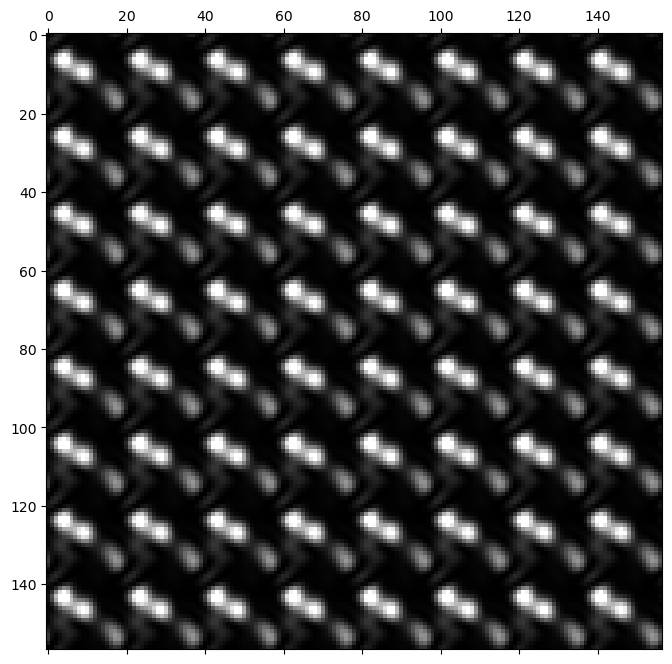

In [90]:

slice = virtual_detector.data[:, :, 0]
show(slice)

We can also visualiz sum of integrated angles, simulating the sliders selecting virtual inner and outer angles in the PRSIM gui


In [91]:
inner_angle = 11
outer_angle = 20
virtual_detected = virtual_detector.data[:, :, inner_angle:outer_angle]
sum_slice = np.sum(virtual_detected, axis=-1)

show(sum_slice)

Here, we generate 4 different looks from different detection angles
- virtual bright field (BF)
- annular bright field (ABF)
- annular dark field (ADF)
- high angle annular dark field (HAADF)

In [98]:
cmap = "gray"

max_angle = virtual_detector.data.shape[-1]

inner_angles = [0, 11, 20, 61]
outer_angles = [20, 20, 40, max_angle]
labels = ["BF", "ABF", "ADF", "HAADF"]

data_list = []

for inner, outer in zip(inner_angles, outer_angles):
    im = virtual_detector.data[:, :, inner:outer]
    data_list.append(np.sum(im, axis=-1))

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)

    inner = inner_angles[i]
    outer = outer_angles[i]

    title = f"{labels[i]}: {inner}-{outer} millirads"
    plt.imshow(data_list[i], cmap=cmap, interpolation=None, resample=False)
    ax.set_title(title)

fig.suptitle(plt_title)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

fpath = f"{plt_bname}_summary.png"
plt.savefig(fpath, bbox_inches="tight")

Save each images as a`.tiff` file

In [93]:
for i in range(4):

    fig = plt.imshow(data_list[i], cmap='gray', interpolation=None, resample=False)
    # fig = PIL.Image.fromarray(sum_slice, cmap='gray', vmin=0, vmax=255, interpolation=None, resample=False)

    plt.axis("off")

    fpath = f"{plt_bname}_{labels[i]}.tiff"
    plt.savefig(fpath, bbox_inches="tight", pad_inches=0)